In [1]:
import os
import sys
import time
import datetime
import json
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
import math
import PIL
from PIL import Image
import umap
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import cm
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
# import torchvision.datasets as datasets
import torchvision.utils as vutils
from util.pos_embed import interpolate_pos_embed
from util import datasets

import models_mae
import models_vit

print(np.__version__)
print(pd.__version__)
print(torch.__version__)

path_meta = Path('meta')
path_meta.mkdir(exist_ok=True, parents=True)
path_embeddings = Path('embedding')
path_embeddings.mkdir(exist_ok=True, parents=True)

1.22.2
1.4.1
1.10.2+cu113


In [2]:
# sys.path.remove('/home/AI_projects/yunghui/Transformer-Explainability')
sys.path

['/home/esslab/AI_projects/yunghui/mae',
 '/home/esslab/anaconda3/envs/mae/lib/python39.zip',
 '/home/esslab/anaconda3/envs/mae/lib/python3.9',
 '/home/esslab/anaconda3/envs/mae/lib/python3.9/lib-dynload',
 '',
 '/home/esslab/anaconda3/envs/mae/lib/python3.9/site-packages',
 '/home/esslab/anaconda3/envs/mae/lib/python3.9/site-packages/IPython/extensions',
 '/home/esslab/.ipython']

In [3]:
import sys
# adding Transformer-Explainability to the system path
sys.path.insert(0, '/home/esslab/AI_projects/yunghui/Transformer-Explainability')
 
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

### Load model

In [4]:
def load_encoder(ck, n_classes:int=1486, global_pool:bool=False, encoder_version:str='iNat_FT', **kwargs):
    # assert encoder_version == 'eBirdPT' or encoder_version =='iNatFT', f'Encoder_version must be either iNatFT or eBirdPT, got {encoder_version}'
    
    # model = models_vit.__dict__['vit_base_patch16'](num_classes=n_classes, global_pool=global_pool, )
    model = vit_LRP(num_classes=n_classes).cuda()
    
    checkpoint = torch.load(ck, map_location='cpu')
    checkpoint_model = checkpoint['model']
    state_dict = model.state_dict()

    # interpolate position embedding
    interpolate_pos_embed(model, checkpoint_model)

    # load pre-trained model
    msg = model.load_state_dict(checkpoint_model, strict=False)
    print(msg)
    
    return model

In [5]:
encoder_version='eBirdFT' # 'iNatFT', 'eBirdFT' or 'eBirdPT',
norm_pixel = 'on'

global_pool = False
token = 'cls' if global_pool==False else 'gap'
data_src = 'eBirdTop100' #  'iNat', 'eBird', 'eBirdTop100'
path_model = Path('output_dir')


print(f'Encoder  : {encoder_version}')

ck = path_model/'ebird_NPon_eBirdFT_cls11186_vit_base_checkpoint-149.pth'  #　eBird finetuned MAE

v_embedding = f'NP{norm_pixel}(Pretrain)_{encoder_version}{token}(Encoder)_{data_src}(Data)'
print(f'Embedding version : {v_embedding}')


n_classes = 11186
print(f"Load pre-trained checkpoint from: {ck}")
model = load_encoder(ck, n_classes=n_classes, encoder_version=encoder_version)

 

Encoder  : eBirdFT
Embedding version : NPon(Pretrain)_eBirdFTcls(Encoder)_eBirdTop100(Data)
Load pre-trained checkpoint from: output_dir/ebird_NPon_eBirdFT_cls11186_vit_base_checkpoint-149.pth
<All keys matched successfully>


### Load metadata 

In [6]:
%%time

data_path = '../../shared/eBird/download_ebird/downloaded'
val_data = 'jpg_top100'
meta_data =  '../../shared/eBird/download_ebird/meta/jpg_top100_meta5.feather'
df_meta =  pd.read_feather(meta_data)


# Establish sp_id  

col_obj2cat = ['Format', 'Accessory', 'Asset_State', 'isInternalUser', 'mediaDownloadUrl', 'Playback', 'Microphone', 'Recorder', 'Taxon_Category', 
               'Age/Sex', 'Asset_Tags', 'Order', 'Behaviors', 'Country', 'Parent_Dir', 'Family', 'Background_Species', 'Genus', 'State', 'County']
for col in col_obj2cat :
    df_meta[col] =  df_meta[col].astype('category') 

col_label = ['Label'] 
col_basic = ['ML_Catalog_Number', 'Dir_FName']
col_file = ['Dir_FName', 'Parent_Dir', 'Sci_N']
col_taxon = ['Order', 'Family', 'Genus', 'SCI_NAME_2021', 'Sci_Name', 'Parent_Species', 'Taxon_Category']
col_geo = ['Country', 'Latitude', 'Longitude']
col_time = ['Year', 'Month', 'Day']
col_sel = col_label + col_basic + col_taxon + col_geo + col_time
df_meta = df_meta[col_sel].copy()

print(f'# of Order : {df_meta.Order.nunique()}')
print(f'# of Family : {df_meta.Family.nunique()}')
print(f'# of Genus: {df_meta.Genus.nunique()}')

print(df_meta.columns)

# of Order : 41
# of Family : 249
# of Genus: 2295
Index(['Label', 'ML_Catalog_Number', 'Dir_FName', 'Order', 'Family', 'Genus',
       'SCI_NAME_2021', 'Sci_Name', 'Parent_Species', 'Taxon_Category',
       'Country', 'Latitude', 'Longitude', 'Year', 'Month', 'Day'],
      dtype='object')
CPU times: user 6.56 s, sys: 4.72 s, total: 11.3 s
Wall time: 8.13 s


In [7]:
%%time

col_label = ['Label', 'Dir_class']
df_label_= pd.read_feather(meta_data)[col_label].drop_duplicates(subset=col_label) 
df_label_

CPU times: user 1.94 s, sys: 3.18 s, total: 5.12 s
Wall time: 1.95 s


,Label,Dir_class
0,3090,Acanthisitta_chloris
100,3091,Xenicus_gilviventris
200,3092,Acanthiza_apicalis
300,3093,Acanthiza_chrysorrhoa
400,3094,Acanthiza_cinerea
...,...,...
896502,9656,Zosterornis_hypogrammicus
896512,9657,Zosterornis_latistriatus
896515,9658,Zosterornis_nigrorum
896519,9659,Zosterornis_striatus


In [8]:
CLS2IDX_ = (df_label_.sort_values(by=['Label']).dropna(subset=['Dir_class']))
CLS2IDX = {l_: cls_ for l_, cls_ in zip(CLS2IDX_.Label.values, CLS2IDX_.Dir_class.values)}
print(len(CLS2IDX))
IDX2CLS = {cls_: l_  for l_, cls_ in zip(CLS2IDX_.Label.values, CLS2IDX_.Dir_class.values)}

11186


## Import "Transformer-Explainability" modules
- [CVPR 2021] [Official PyTorch implementation for Transformer Interpretability Beyond Attention Visualization, a novel method to visualize classifications by Transformer based networks.](https://arxiv.org/abs/2012.09838)


In [9]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

In [ ]:
# initialize ViT pretrained
# model = vit_LRP().cuda()
model.eval()
attribution_generator = LRP(model)

In [ ]:
def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)
    return class_indices

In [75]:
figsize=(12,8)

Top 5 classes:
	11016 : Tyto_alba                        		value = 9.326	 prob = 24.6%
	1324 : Charadrius_alexandrinus          		value = 7.928	 prob = 6.1%
	1339 : Charadrius_mongolus              		value = 7.097	 prob = 2.7%
	1340 : Charadrius_mongolus_leschenaultii		value = 6.434	 prob = 1.4%
	1344 : Charadrius_obscurus              		value = 6.108	 prob = 1.0%


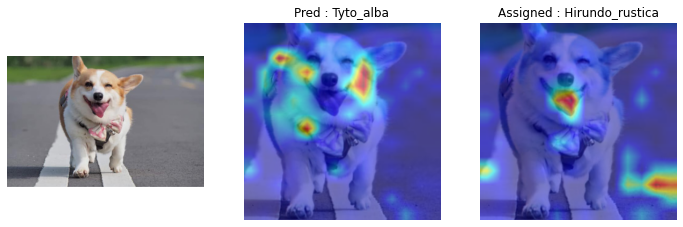

In [104]:
image = Image.open('temp/coca.jpg')
image_ = transform(image)

output = model(image_.unsqueeze(0).cuda())
class_indices = print_top_classes(output)
cls_pred_top1 = CLS2IDX[class_indices[0]]

# cat - the predicted class
pred = generate_visualization(image_)

# True or Assigned cls
cls_ = 'Hirundo_rustica'
# generate visualization for class 4864243: 'Hirundo_rustica'
img_assigned = generate_visualization(image_, class_index=IDX2CLS[cls])


fig, axs = plt.subplots(1, 3, figsize=figsize)
# fig(figsize=(6,4))
axs[0].imshow(image);
axs[0].axis('off');

axs[1].imshow(pred);
axs[1].axis('off');
axs[1].set_title(f'Pred : {cls_pred_top1}');
axs[2].imshow(img_assigned);
axs[2].axis('off');
axs[2].set_title(f'Assigned : {cls_}');



Top 5 classes:
	10273 : Oceanites_oceanicus 		value = 8.841	 prob = 28.8%
	10248 : Oceanodroma_castro  		value = 6.959	 prob = 4.4%
	10272 : Oceanites_gracilis  		value = 6.919	 prob = 4.2%
	10247 : Hydrobates_pelagicus		value = 6.761	 prob = 3.6%
	10265 : Oceanodroma_tethys  		value = 6.291	 prob = 2.2%


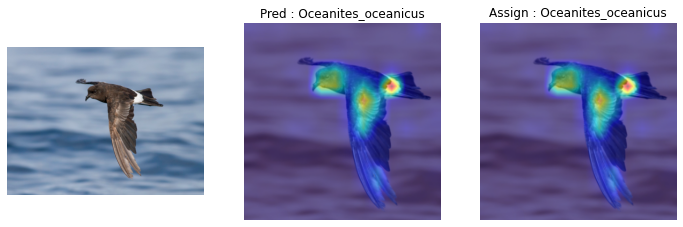

In [120]:
image = Image.open('temp/seabird_1.jpg').convert('RGB') 
image_ = transform(image)

output = model(image_.unsqueeze(0).cuda())
class_indices = print_top_classes(output)
cls_pred_top1 = CLS2IDX[class_indices[0]]

# cat - the predicted class
pred = generate_visualization(image_)

# True or Assigned cls
cls_ = 'Oceanites_oceanicus'
# generate visualization for class 4864243: 'Hirundo_rustica'
img_assigned = generate_visualization(image_, class_index=IDX2CLS[cls_])


fig, axs = plt.subplots(1, 3, figsize=figsize)
# fig(figsize=(6,4))
axs[0].imshow(image);
axs[0].axis('off');

axs[1].imshow(pred);
axs[1].axis('off');
axs[1].set_title(f'Pred : {cls_pred_top1}');
axs[2].imshow(img_assigned);
axs[2].axis('off');
axs[2].set_title(f'Assign : {cls_}');


Top 5 classes:
	10248 : Oceanodroma_castro   		value = 8.026	 prob = 14.3%
	10273 : Oceanites_oceanicus  		value = 6.946	 prob = 4.9%
	10247 : Hydrobates_pelagicus 		value = 6.579	 prob = 3.4%
	10254 : Oceanodroma_leucorhoa		value = 6.480	 prob = 3.1%
	10272 : Oceanites_gracilis   		value = 6.378	 prob = 2.8%


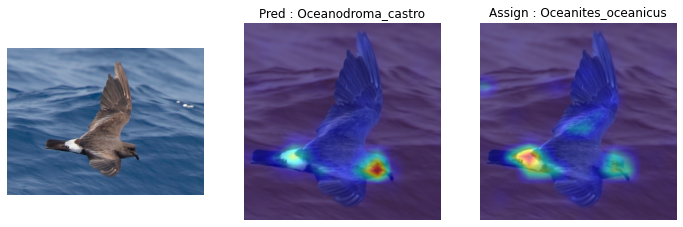

In [121]:
image = Image.open('temp/seabird_2.jpg').convert('RGB') 
image_ = transform(image)

output = model(image_.unsqueeze(0).cuda())
class_indices = print_top_classes(output)
cls_pred_top1 = CLS2IDX[class_indices[0]]

# cat - the predicted class
pred = generate_visualization(image_)

# True or Assigned cls
cls_ = 'Oceanites_oceanicus'
# generate visualization for class 4864243: 'Hirundo_rustica'
img_assigned = generate_visualization(image_, class_index=IDX2CLS[cls_])


fig, axs = plt.subplots(1, 3, figsize=figsize)
# fig(figsize=(6,4))
axs[0].imshow(image);
axs[0].axis('off');

axs[1].imshow(pred);
axs[1].axis('off');
axs[1].set_title(f'Pred : {cls_pred_top1}');
axs[2].imshow(img_assigned);
axs[2].axis('off');
axs[2].set_title(f'Assign : {cls_}');


---

## Get LPR * grad from last layer

In [ ]:
image = Image.open('temp/seabird_2.jpg').convert('RGB') 
image_ = transform(image)
inputs = image_.unsqueeze(0).cuda()

#### def get_LPR_score_head()

In [ ]:

def get_LPR_score_head(inputs_, model, index=None, 
                       method="transformer_attribution", is_ablation=False, start_layer=0, **kwargs) ->torch.tensor: 

    kwargs = {"alpha": 1}
    output = model(inputs_)
    if index is None : 
        index = np.argmax(output.cpu().data.numpy(), axis=-1)

    one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
    one_hot[0, index] = 1
    one_hot_vector = one_hot
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot_sum = torch.sum(one_hot.cuda() * output)
    model.zero_grad()
    one_hot_sum.backward(retain_graph=True)

    rel_score  = model.head.relprop(torch.tensor(one_hot_vector).to(inputs_.device), **kwargs) # shape : (batch, dim). dim=768

    return rel_score

In [ ]:
rel_score_  = get_LPR_score_head(inputs, model, index=None)
print(rel_score_.shape)

torch.Size([1, 768])


In [ ]:
rel_score_ = model.head.relprop(torch.tensor(one_hot_vector).to(input.device), **kwargs) # shape : (batch, dim). dim=768
print(rel_score_.shape)

torch.Size([1, 768])


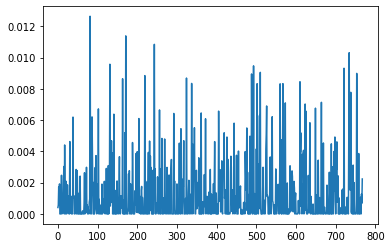

In [ ]:
plt.plot(rel_score_head.reshape(-1).cpu().data.numpy())

#### def get_grad_head()

In [ ]:
def get_grad_head(inputs_, model, index=None, **kwargs)->torch.tensor:
    embedding_ = model.forward_features(inputs_) # shape:(n_batch, dim). 
    features_ =  embedding_.clone().detach().to(inputs_.device).requires_grad_(True)
    pred = model.head(features_)  # (n_batch, n_classe)

    # Whether to use the ground truth label, or predicted by model
    if index is None :               
        index = np.argmax(pred.detach().cpu().numpy(), axis=1)  # return (n_batch, n_classes)

    # one_hot encoding labels 
    one_hot = F.one_hot(torch.tensor(index).clone().detach() , num_classes=n_classes).to(inputs_.device) # (n_batch, n_classe)
    pred.backward(one_hot)                             

    # grads of embeddings. shape:(n_batch, dim). 
    inputs_grad_ = features_.grad.clone().detach()
    return inputs_grad_

In [ ]:
grad_ = get_grad_head(image_.unsqueeze(0).cuda(), model)
grad_.shape

torch.Size([1, 768])

In [ ]:
# filter label > 0
mask_label_positive = df_meta.Label >= 0

data_path = '../../shared/eBird/download_ebird/downloaded'
val_data = 'jpg_top100'
meta_data =  '../../shared/eBird/download_ebird/meta/jpg_top100_meta5.feather'
files_path_  = list(data_path + '/' +  val_data + '/' + df_meta[mask_label_positive].Dir_FName	+ '.jpg')
labels = df_meta[mask_label_positive].Label.values
print(f'Original data size : {len(df_meta):,d}  After filter "label > 0" : {len(files_path_):,d}')
assert len(files_path_) == len(labels)
assert  df_meta.Label.dtype == 'int64'

Original data size : 896,555  After filter "label > 0" : 896,195


In [ ]:
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

batch_size = 100

mean, std = IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
# simple augmentation
transform_toTensor = transforms.Compose([transforms.Resize(256), 
                                         transforms.CenterCrop(224), 
                                         transforms.ToTensor(), 
                                         transforms.Normalize(mean, std)])


dataset = datasets.ImageDatasetFromFile(files_path_, labels, transform=transform_toTensor)
print(len(dataset))

# sampler = torch.utils.data.RandomSampler(dataset)
data_loader = torch.utils.data.DataLoader(
        dataset, pin_memory=True, drop_last=False, shuffle=False,
        num_workers=10,  batch_size=batch_size,)
print(len(data_loader))

896195
8962


In [ ]:
# get_grad_head(imgs, model, index=labels.numpy())
rel_grads.shape

(896195, 768)

In [ ]:
%%time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
# encoder.eval()
# encoder.to(device)

start_time = time.time()
for i, (imgs, labels)  in enumerate(data_loader):

    imgs = imgs.to(device, non_blocking=True)
    rel_score_  = get_LPR_score_head(imgs, model, index=labels.numpy())
    grad_ = get_grad_head(imgs, model, index=labels.numpy())
    rel_grad_ = (torch.clip( grad_, min=0)*rel_score_).cpu().data.numpy()


    rel_grads = rel_grad_ if i == 0 else np.concatenate((rel_grads, rel_grad_), axis=0) 
    
    passing_time = str(datetime.timedelta(seconds=int(time.time() - start_time )))
    info = f'Progress:{i+1:4d}, {100*(i+1)/len(data_loader):3.2f}%. ' 
    info += f'| Feature_shape: {rel_grads.shape}.' 
    info += f'| Time: {passing_time}. '
    print(info, end='\r')
    # if i>10 :break


CPU times: user 3h 24min 23s, sys: 1h 54min 46s, total: 5h 19min 10s47. 
Wall time: 3h 40min 47s


In [ ]:
%%time
file_ = f'rel_grads_{v_embedding}.npz'
print(f'{file_}')
np.savez_compressed(path_embeddings/file_, rel_grads=rel_grads)
# print(f'{file_} saved')
# np.save(path_embeddings.joinpath(file_) , embeddings)
rel_grads = np.load(path_embeddings/file_)['rel_grads']
print(rel_grads.shape)

# df_embedding = pd.DataFrame(embeddings)
# df_embedding

rel_grads_NPon(Pretrain)_eBirdFTcls(Encoder)_eBirdTop100(Data).npz
(896195, 768)
CPU times: user 2min 7s, sys: 2.42 s, total: 2min 9s
Wall time: 2min 9s


In [ ]:
rel_grads.shape

(896195, 768)

In [ ]:
pd.DataFrame(rel_grads.reshape(-1)).describe()

,0
count,6.882778e+08
mean,1.306675e-04
std,4.420232e-04
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,4.659505e-05
max,6.441317e-02


CPU times: user 6.81 s, sys: 343 µs, total: 6.81 s
Wall time: 6.81 s


(array([6.71848334e+08, 1.19329630e+07, 2.91788000e+06, 9.44210000e+05,
        3.55650000e+05, 1.47951000e+05, 6.62170000e+04, 3.11050000e+04,
        1.53850000e+04, 7.98800000e+03, 4.31400000e+03, 2.39500000e+03,
        1.37000000e+03, 7.72000000e+02, 4.63000000e+02, 2.99000000e+02,
        1.66000000e+02, 1.11000000e+02, 6.90000000e+01, 4.80000000e+01,
        2.10000000e+01, 1.30000000e+01, 8.00000000e+00, 6.00000000e+00,
        5.00000000e+00, 5.00000000e+00, 2.00000000e+00, 4.00000000e+00,
        2.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00]),
 array([0.        , 0.00128826, 0.00257653, 0.00386479, 0.00515305,
        0.00644132, 0.0077

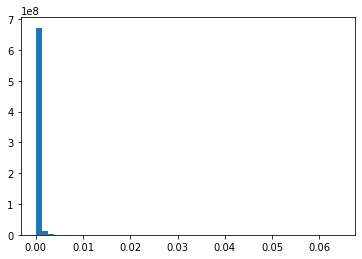

In [ ]:
%%time
plt.hist(rel_grads.reshape(-1) ,bins=50);

CPU times: user 49.1 s, sys: 877 ms, total: 50 s
Wall time: 50 s


''

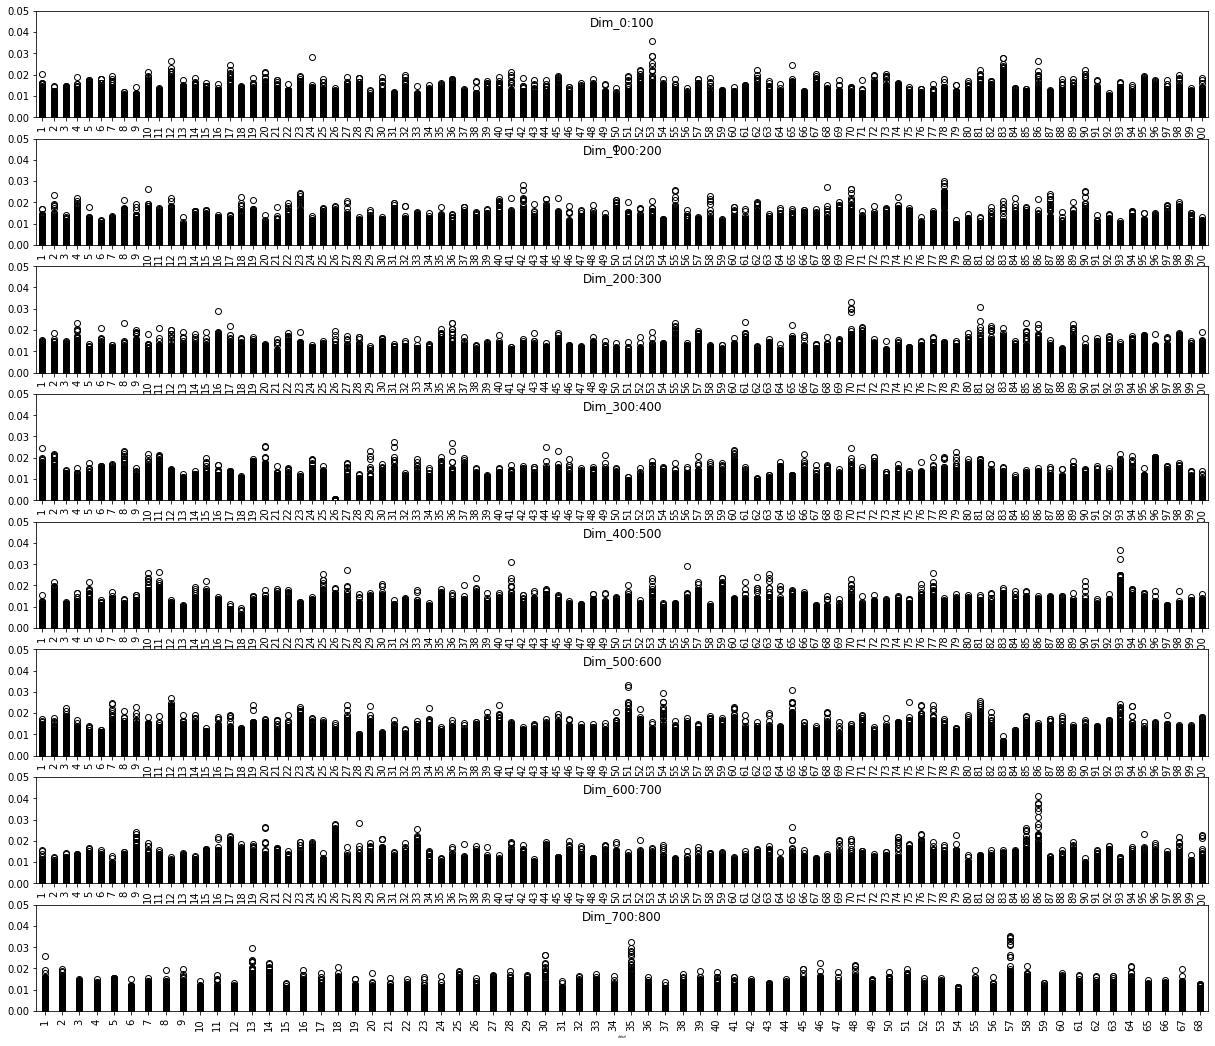

In [ ]:
%%time
interval = 100
n, d = rel_grads.shape
start=0
row=int(np.ceil(d/interval))
h = row*2.3
fig, axs = plt.subplots(row,figsize=(21,h))
for r in range(row):
    slice_ = rel_grads[:, start : start+interval]
    axs[r].boxplot(slice_)
    axs[r].set_title(f'Dim_{start}:{start+interval}', y=0.8)
    axs[r].tick_params(axis='x', labelrotation=90)
    axs[r].set_xlabel('xlabel', fontsize=3)
    axs[r].set_ylim([0, 0.05])
    start += interval
;

CPU times: user 3min 39s, sys: 1min 36s, total: 5min 15s
Wall time: 23.2 s


<timed exec>:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


''

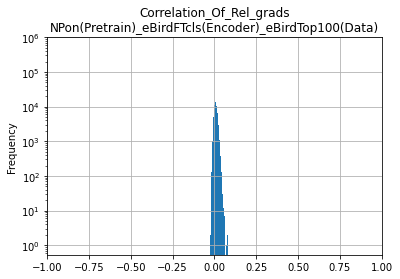

In [ ]:
%%time
title = f'Correlation_Of_Rel_grads\n{v_embedding}'

corr_matrix = np.corrcoef(np.transpose(rel_grads))
# mask =  np.triu(np.ones_like(corr_matrix, dtype=bool))

xlim=(-1,1)
ylim=(0,1e6)
figsize = (6,4)

fig, ax = plt.subplots(figsize = figsize )
ax.hist(np.tril(corr_matrix ,k=-1).reshape(-1,1), bins=100)

ax.grid(True)
ax.set_yscale('log')
ax.set(title=title,  ylabel='Frequency',  xlim=xlim, ylim=ylim)
;